In [1]:
from transformers import AutoProcessor
from datasets.features import ClassLabel
from datasets import load_dataset 
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
import torch

g:\IDEs and Modules\Anaconda\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")
tokenizer = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

Found cached dataset funsd-layoutlmv3 (C:/Users/csara/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)
100%|██████████| 2/2 [00:00<00:00, 73.99it/s]


In [3]:
model = LayoutLMv3ForTokenClassification.from_pretrained(r"G:/Form understanding in Noisy scanned documents/trained_model")

In [4]:
device = torch.device("cuda")
model.cuda()

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [5]:
example = dataset["test"][2]
print(example.keys())

image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = tokenizer(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
encoding = encoding.to('cuda')
for k,v in encoding.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model.to('cuda')(**encoding)

logits = outputs.logits
logits.shape

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])
input_ids torch.Size([1, 372])
attention_mask torch.Size([1, 372])
bbox torch.Size([1, 372, 4])
labels torch.Size([1, 372])
pixel_values torch.Size([1, 3, 224, 224])


g:\IDEs and Modules\Anaconda\envs\pytorch_gpu\lib\site-packages\transformers\modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 372, 7])

In [6]:
predictions = logits.argmax(-1).squeeze().tolist()


labels = encoding.labels.squeeze().tolist()

In [7]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

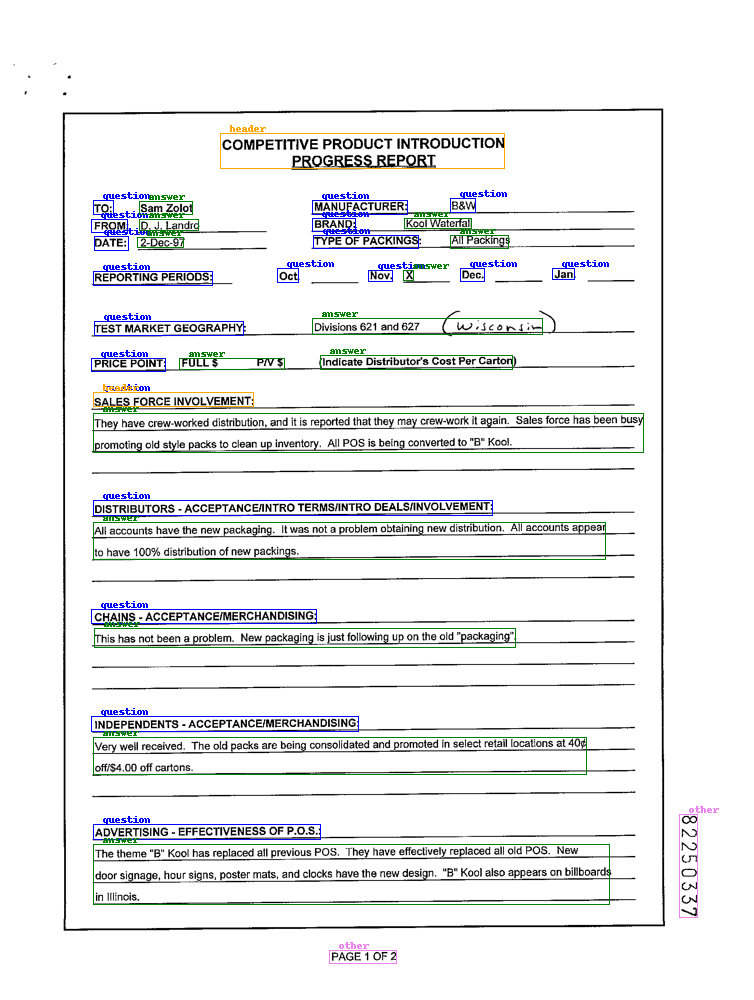

In [8]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image